 **Kurze Erklärung zum Programm**

# Markowitz (Mean-Variance) Model

--- 

Hier stelle ich kurz das Grundliegende Model der Portfoliotheorie vor: Das Markowitz Model!


Wenn die Schwankung der täglichen Renditen verschiedener Aktien ungefähr Normal verteilt ist, kann man die Gewichtung so kombinieren das die Schwankung des Portfolios kleiner ist als die Schwakung der einzelnen Titel ("Minimumvarianzprinzip")

---




In [1]:
# Hier im ersten Block werden Libraries für die Berechnung des Portfolios importiert 

import decimal
import pandas as pd
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers
import quandl
import matplotlib.pyplot as plt
# API configuration here
quandl.ApiConfig.api_key = "VAA5bZ67DimoDkvMStuG"
solvers.options['show_progress'] = False
import matplotlib.pyplot as plt

In [2]:
# Hier werden die Aktien oder Anleihen in einer Liste geladen
# stocklist und bond list muss klar unterschieden werden

stocklist = ['AMD', 'NVDA', 'OKE', 'CHK', 'NEM', 'AMAT', 'ALB', 'FCX', 'HPE', 'IDXX', 'WMB']

'''
stocklist = ['AMD', 'NVDA', 'OKE', 'CHK', 'NEM', 'AMAT', 'ALB', 'FCX', 'HPE', 'IDXX', 'WMB',
        'DHR', 'WYNN', 'PWR', 'ALGN', 'MU', 'CHTR', 'AVGO', 'CMA', 'NAVI', 'NUE', 'DLR', 'CNP', 'SYMC', 'RF',
        'MCHP', 'SYY', 'LRCX', 'FMC', 'ROST', 'TWX', 'MLM', 'STX', 'UNH', 'VTR', 'DRE', 'DGX', 'PLD', 'HP',
        'UAL', 'GLW', 'KEY', 'BBY', 'DE', 'CMI', 'WM', 'MGM', 'SNI', 'CFG', 'ZION', 'HAL', 'RSG', 'DRI', 'PKG']

'''

# small list of Bond Etfs
bondlist = ['AGG', 'BND', 'LQD']





In [3]:
# Hier werden die Preise von der Quandl Datenbank gezogen

data = quandl.get_table('WIKI/PRICES', ticker = stocklist, 
                        qopts = { 'columns': ['ticker', 'date', 'adj_close'] },
                        date = { 'gte': '2016-12-31', 'lte': '2017-12-31' }, 
                        paginate=True)

new = data.set_index('date')

# use pandas pivot function to sort adj_close by tickers
clean_data = new.pivot(columns='ticker')

# check the head of the output
#clean_data.head()



## In der nächsten Zeile können Sie die Modellparameter bestimmen 

---

**Wichtig ist das man das Maixmalgewicht nicht unterschreitet, da sonst die Gewichte in keinem Fall auf 100% kommen können und das das Programm eine Fehlermeldung wiedergibt**

Generell sollte das minimale und maximale Gewicht pro Wertpapier zwischen -1.0 und 1.0 liegen (-100% und 100%) 

---



In [4]:
# hier kann man die Modelparameter anpassen:

#Gewichtung im Model
Minimal_gewicht = -0.0
Maximal_gewicht = 2.0

#Scale of Optimization
Scale = 100 #usually set to 100

Riskaversion = 99 #have to figure out how to make it proportional to the Scale 

#historical data from beginning to end

#data_start = 
#data_end = 


x = decimal.Decimal(100/len(stocklist))
print("Achtung! das Maximale Gewicht (Maximal_gewicht) darf ", round(x,3) , "% nicht unterschreiten!")


Achtung! das Maximale Gewicht (Maximal_gewicht) darf  9.091 % nicht unterschreiten!


In [5]:
# here I will transform the data to be suitable for the model used

returnss = (clean_data.pct_change().dropna())
number = len(stocklist)


#clean_data.plot(figsize=(15, 10))
#print(returns.as_matrix)
returns = returnss.values #as_matrix()
print((returns.shape))



(249, 11)


In [6]:
def optimal_portfolio(returns):
    n = len(returns)
    #returns = np.diff(returns)
    returns = np.asmatrix(returns)
    
    G = Scale

    #G = 100
    mus = [10**(5.0 * t/G - 1.0) for t in range(G)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns)) #np.diff(returns1)
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    
    # new constraint matrices for negative weights and weight adjustment
    dank = -np.array(np.eye(n))
    dabbie = np.array(np.eye(n))
    ye = np.vstack((dank, dabbie))
    deed = np.ones((2*n ,1))
    G = opt.matrix(ye, tc='d')
    #h = opt.matrix(deed, tc='d')
    #G = opt.matrix(np.r_[-np.eye(n), np.eye(n)], tc='d')
    #h = opt.matrix(np.r_[np.zeros((n,1)) +1 , np.zeros((n,1)) + 1], tc='d')
    
    d = -np.ones((n,1))*Minimal_gewicht #0.02
    e = np.ones((n,1))*Maximal_gewicht #0.050
    dodo = np.vstack((d, e))
    h = opt.matrix(dodo, tc='d')

        
    # Create constraint matrices do not uncomment G & H
    #G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    #h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                 for mu in mus]
    t=portfolios

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER  (will add back later)
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE and Maximum Return Portfolio
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt((m1[2])/ m1[0]) ##change for desired portfolio this solves for horizontal tangent portfolio (not now)
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    
    
    ## approximates the maximum Sharpe portfolio (also called tangent portfolio)
    #slope = (returns-(rf/252))/risks
    #opt_s_ind = slope.argmax()
    
    return np.asarray(wt), returns, risks, t

results,_,risk,tp = optimal_portfolio(returns.T) #np.diff(returns1) returns3
Riskaversion =99
# index portfolios on the efficient frontier here
test1=np.array(opt.matrix(tp))
sublist=[test1[n:n+number] for n in range(0,len(test1),number)]
real=sublist[Riskaversion]


In [7]:
#show portfolio weights here, some data engineering  

l = np.array(stocklist)
dic = {}
for i in range(len(stocklist)):
    dic[stocklist[i]] = real[i]

s = pd.Series(dic, index=stocklist)
df = s[abs(s) > 0.0005]
df=df.astype(float)


AMD     0.113490
NVDA    0.120503
AMAT    0.067084
ALB     0.148188
FCX     0.231724
HPE     0.009701
IDXX    0.125368
WMB     0.183941
dtype: float64


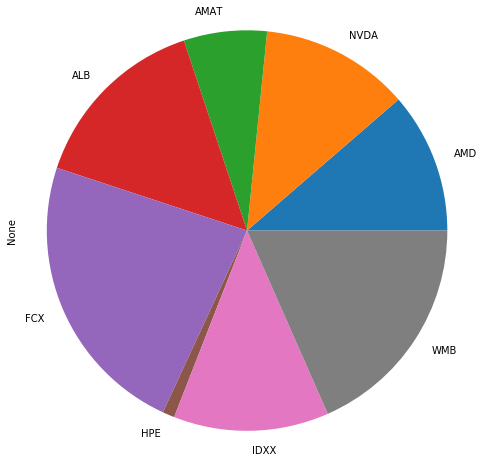

In [8]:
abs(df).plot.pie(y=None) 
plt.axis('equal')
print(df)

fig = plt.gcf()
fig.set_size_inches(8,8)


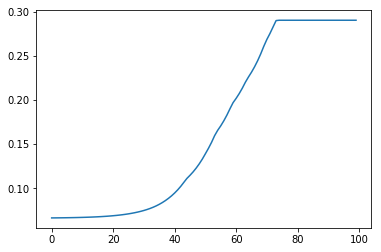

In [9]:
# risiko zu rendite 
t = Scale
scale = [t for t in range(t)] 
sclae = scale.reverse()
rendite = np.array(_)*100

plt.plot(scale,rendite)
#print(scale)

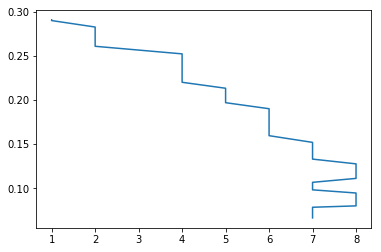

In [10]:
# relationship between number of assets in a portfolio (weighted more than 0.001) and return

def counting():
    count = []
    for lists in sublist:
        newlist = []
        for i in lists:
            if (i >= 0.02):
                newlist.append(i)
        count.append(len(newlist))
    return count
q = counting()



plt.plot(q, rendite)

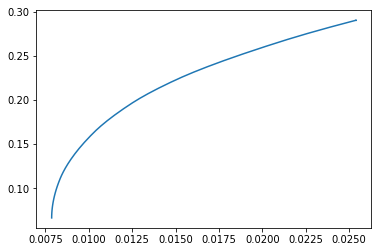

In [11]:
#classic markowitz bullet
plt.plot(risk, rendite)

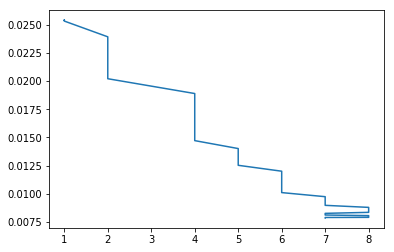

In [12]:
#risk and number of stocks in a portfolio
plt.plot(q, risk)

In [13]:
# zu erwartende Tagesrendite (basierend auf historischen renditen) des optimalen portfolios 

exp_returns = returnss.mean()
exp_returns = exp_returns.values
exp_returns = exp_returns.reshape(len(exp_returns),1)

expected_portfolio_return = np.dot(real.T, exp_returns)

print(expected_portfolio_return)


[[0.00066388]]


In [17]:
yet = 2* rendite*0.3 + rendite*(-0.1)
print(yet.mean())

rf = 0.01

0.0831957592381703


In [18]:
def optimal_portfolio(returns):
    n = len(returns)
    #returns = np.diff(returns)
    returns = np.asmatrix(returns)
    
    G = Scale

    G = 100
    mus = [10**(5.0 * t/G - 1.0) for t in range(G)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns)) #np.diff(returns1)
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # new constraint matrices for negative weights and weight adjustment
    dank = -np.array(np.eye(n))
    dabbie = np.array(np.eye(n))
    ye = np.vstack((dank, dabbie))
    deed = np.ones((2*n ,1))
    G = opt.matrix(ye, tc='d')
    #h = opt.matrix(deed, tc='d')
    #G = opt.matrix(np.r_[-np.eye(n), np.eye(n)], tc='d')
    #h = opt.matrix(np.r_[np.zeros((n,1)) +1 , np.zeros((n,1)) + 1], tc='d')
    
    d = -np.ones((n,1))*Minimal_gewicht #0.02
    e = np.ones((n,1))*Maximal_gewicht #0.050
    dodo = np.vstack((d, e))
    h = opt.matrix(dodo, tc='d')

        
    # Create constraint matrices do not uncomment G & H
    #G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    #h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                 for mu in mus]
    t=portfolios

    ## CALCULATE RISKS AND RETURNS FOR FRONTIER  (will add back later)
    returns = np.asarray([blas.dot(pbar, x) for x in portfolios])
    risks = np.asarray([np.sqrt(blas.dot(x, S*x)) for x in portfolios])
    
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    #m1 = np.polyfit(returns, risks, 2)
    #x1 = np.sqrt((m1[2])/ m1[0]) ##change for desired portfolio this solves for horizontal tangent portfolio (not now)

    # CALCULATE THE OPTIMAL PORTFOLIO
    
    slope = (returns-(rf/252))/risks
    opt_s_ind = slope.argmax()
    return np.asarray(portfolios[opt_s_ind]), np.asarray(returns), np.asarray(risks), portfolios, dodo, G 
    
    
    
    #wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    #return np.asarray(wt), returns, risks, t, dodo, G

results,_,risk,tp, dodo, G = optimal_portfolio(returns.T) #np.diff(returns1) returns3
Riskaversion =99
# index portfolios on the efficient frontier here
test1=np.array(opt.matrix(tp))
sublist=[test1[n:n+number] for n in range(0,len(test1),number)]
real=sublist[Riskaversion]

#print(real.round(5))

#print(sum(abs(real)))
G = np.array(G)
print(results.round(4))


[[0.2647]
 [0.2386]
 [0.    ]
 [0.    ]
 [0.0771]
 [0.    ]
 [0.1772]
 [0.0874]
 [0.1549]
 [0.    ]
 [0.    ]]


In [19]:
print(sum(results))

[1.]
